# Bayesian Parameter Estimation and Complete Analysis

In [1]:
import sys
import numpy as np
import pandas as pd
import pystan
import altair as alt
sys.path.insert(0, '../../')
import mut.bayes
import mut.stats
import mut.thermo
import mut.viz
alt.themes.register('pboc', mut.viz.altair_config)
alt.data_transformers.enable('json')
alt.themes.enable('pboc')

ThemeRegistry.enable('pboc')

This notebook serves as a guide for the complete analysis of all collected data so far. Unless otherwise specified, parameters are taken as delta functions at their reported literature values. 

---

##  Loading and cleaning of data
Below, we load the total compiled data and split it into the three classes. We also trim the data to fitwithin realistic bounds accounting for some degree of homoscedastic error (i.e. fold-change between -0.2 and 1.2, assuming that measurement noise may bring us out of the physically restricted range of $\in [0, 1]$.

In [2]:
# Load the data and restrict to physically reasonable bounds
full_data = pd.read_csv('../../data/csv/compiled_data.csv')
data = full_data[(full_data['fold_change'] >= -0.2) & 
                 (full_data['fold_change'] <= 1.2) & 
                 (full_data['operator']=='O2')]

# Split the data into the appropriate classes
DNA_data = data[data['class']=='DNA'].copy()
IND_data = data[data['class']=='IND'].copy()
DBL_data = data[data['class']=='DBL'].copy()
WT_data = data[data['class']=='WT'].copy()

# Compute the mean and standard deviations for each for simple plotting
summarized_data = pd.DataFrame(data.groupby(['mutant', 'class', 'IPTGuM', 
                                  'repressors']).apply(mut.stats.compute_mean_sem)).reset_index()
DNA_summ = summarized_data[summarized_data['class']=='DNA'].copy()
IND_summ = summarized_data[summarized_data['class']=='IND'].copy()
DBL_summ = summarized_data[summarized_data['class']=='DBL'].copy()
WT_summ = summarized_data[summarized_data['class']=='WT'].copy()

# Assign the experimental constants. 
constants = {'ep_AI':4.5, 'O2':-13.9, 'O1':-15.3, 'O3':-9.3, 'Nns':4.6E6, 'n_sites':2, 'ka':139, 'ki':0.53, 'RBS1027':260}

# Part I: Naïve Model for DNA Binding Mutations - No Epistasis

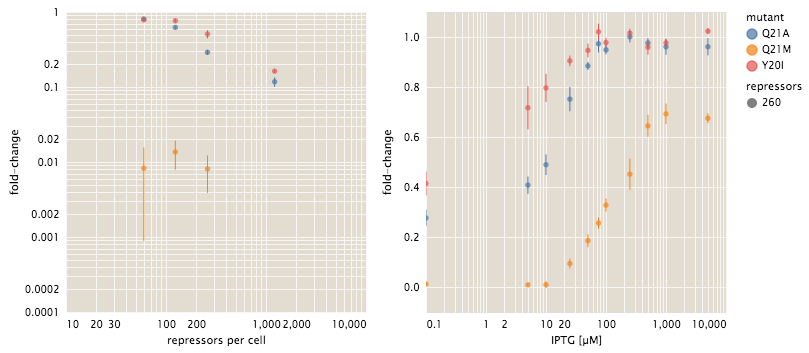

In [3]:
# Set up the two base plots
leak_base = alt.Chart(DNA_summ[(DNA_summ['IPTGuM']==0) & 
                               (DNA_summ['mean'] > 0)], width=300, height=300)
ind_base = alt.Chart(DNA_summ[(DNA_summ['IPTGuM'] > 0) & (DNA_summ['repressors'] == constants['RBS1027'])], width=300, height=300)

# Plot the leakiness data first. 
leak_points = leak_base.mark_point(filled=True).encode(
                x=alt.X('repressors:Q', scale=alt.Scale(type='log'), axis={'title':'repressors per cell'}),
                y=alt.Y('mean:Q', scale=alt.Scale(type='log'), axis={'title':'fold-change'}),
                color='mutant:N').interactive()

leak_err = leak_base.mark_rule().encode(
                x=alt.X('repressors:Q', scale=alt.Scale(type='log'), axis=alt.Axis(title='repressors per cell')),
                y='ymin:Q', y2='ymax:Q',
                color='mutant:N'
            ).transform_calculate(
                ymin='datum.mean - datum.sem',
                ymax='datum.mean + datum.sem'
            )

ind_points = ind_base.mark_point(filled=True).encode(
                x=alt.X('IPTGuM:Q', scale=alt.Scale(type='log'), axis={'title':'IPTG [µM]'}),
                y=alt.Y('mean:Q', axis={'title':'fold-change'}),
                color='mutant:N',
                shape='repressors:N').interactive()

ind_err = ind_base.mark_rule().encode(
                x=alt.X('IPTGuM:Q', scale=alt.Scale(type='log')),
                y='ymin:Q', y2='ymax:Q',
                color='mutant:N'
            ).transform_calculate(
                ymin='datum.mean - datum.sem',
                ymax='datum.mean + datum.sem')

(leak_points + leak_err) | (ind_points + ind_err)

Now that we have a sense of how the data behaves, we can move forward with performing the analysis. I've written a stan model which fits the DNA binding energy in log scale. The stan model can be seen below:

In [4]:
# Load the stan model code. 
ep_RA_model_code = mut.bayes.assemble_StanModelCode('../stan/DNA_binding_energy.stan', '../stan/functions.stan')
ep_RA_model = pystan.StanModel(model_code=ep_RA_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_760d7f07cbd488c340a8441b127f9d4f NOW.


_exec_command_posix failed (status=2)


KeyboardInterrupt: 

In [9]:
# Add mutant identifiers to DNA data

DNA_idx = {m:i+1 for i, m in enumerate(DNA_data['mutant'].unique())}
for m, i in DNA_idx.items():
    DNA_data.loc[DNA_data['mutant']==m, 'idx'] = i
DNA_data['idx'] = DNA_data['idx'].values.astype(int)
leak_data = DNA_data[DNA_data['IPTGuM']==0]

# Assemble the data dictionary and sample
data_dict = dict(J=len(DNA_idx), N=len(leak_data), idx=leak_data['idx'],
                R=leak_data['repressors'], Nns=constants['Nns'], ep_ai=constants['ep_AI'],
                n_sites=constants['n_sites'], fc=leak_data['fold_change'])
ep_RA_samples = ep_RA_model.sampling(data_dict, iter=5000, chains=4)

NameError: name 'ep_RA_model' is not defined

In [9]:
# Convert the samples to a data frame. 
ep_RA_df = mut.bayes.chains_to_dataframe(ep_RA_samples)

# Rename to the correct values
new_names = {'ep_RA.{}'.format(i):'ep_RA.{}'.format(m) for m, i in DNA_idx.items()}
ep_RA_df.rename(columns=new_names, inplace=True)
ep_RA_stats = mut.stats.compute_statistics(ep_RA_df)

NameError: name 'ep_RA_samples' is not defined

**TODO: Write plotting function for MCMC samples**

With the sampling converged and a large number of effective samples, we can compute and plot the credible regions for each.  

In [10]:
# Find the most-likely values for ep_RA
ep_RA_mode = ep_RA_df.iloc[np.argmax(ep_RA_df['logp'].values)]

# Create a dataframe with the credible region and best fit values. 
rep_range = np.logspace(0, 4, 200)
c_range = np.logspace(-2, 4, 200)
leak_dfs = []
ind_dfs = []
for m, i in DNA_idx.items():
    # Compute the best-fit value for leakiness.
    best_fit = mut.thermo.SimpleRepression(rep_range, 
                                           ep_r=ep_RA_mode['ep_RA.{}'.format(m)],
                                          ep_ai=constants['ep_AI'], n_ns=constants['Nns'], 
                                          effector_conc=0, n_sites=constants['n_sites'],
                                          ka=constants['ka'], ki=constants['ki']).fold_change()
    
    # Compute the credible region for the leakiness.
    cred_region = np.zeros([2, len(rep_range)])
    for j, r in enumerate(rep_range):
        arch = mut.thermo.SimpleRepression(r, ep_r=ep_RA_df['ep_RA.{}'.format(m)], 
                                         effector_conc=0, ka=constants['ka'], ki=constants['ki'],
                                         ep_ai=constants['ep_AI'], n_sites=constants['n_sites']
                                         ).fold_change()
        cred_region[:, j] = mut.stats.compute_hpd(arch, 0.95)
    
    # Assemble the leakiness data frame
    _df = pd.DataFrame(np.array([rep_range, best_fit, cred_region[0, :], cred_region[1, :]]).T,
                       columns=['repressors', 'best_fit', 'hpd_min', 'hpd_max'])
    _df['mutant'] = m
    leak_dfs.append(_df)
    
    # Compute the induction curves
    best_fit = mut.thermo.SimpleRepression(constants['RBS1027'], 
                                           ep_r=ep_RA_mode['ep_RA.{}'.format(m)],
                                           ep_ai=constants['ep_AI'], n_ns=constants['Nns'], 
                                           effector_conc=c_range, n_sites=constants['n_sites'],
                                           ka=constants['ka'], ki=constants['ki']).fold_change()
    cred_region = np.zeros([2, len(c_range)])
    for j, c in enumerate(c_range):
        arch = mut.thermo.SimpleRepression(constants['RBS1027'], 
                                        ep_r=ep_RA_df['ep_RA.{}'.format(m)],
                                        ep_ai=constants['ep_AI'], n_ns=constants['Nns'], 
                                        effector_conc=c, n_sites=constants['n_sites'],
                                        ka=constants['ka'], ki=constants['ki']).fold_change()
        cred_region[:, j] = mut.stats.compute_hpd(arch, 0.95)
        
    # Assemble the induction DataFrame.
    _df = pd.DataFrame(np.array([c_range, best_fit, cred_region[0, :], cred_region[1, :]]).T,
                      columns=['IPTGuM', 'best_fit', 'hpd_min', 'hpd_max'])
    _df['mutant'] = m
    ind_dfs.append(_df)
    
# Concatenate the two data frames
leak_fit_df = pd.concat(leak_dfs)
ind_fit_df = pd.concat(ind_dfs)

NameError: name 'ep_RA_df' is not defined

In [11]:
# generate the figures. 
leak_fit_base= alt.Chart(leak_fit_df, width=300).interactive()
ind_fit_base = alt.Chart(ind_fit_df, width=300).interactive()

# modes
leak_fit_mode = leak_fit_base.mark_line().encode(
                x=alt.X('repressors:Q', scale={'type':'log'}, axis={'title':'repressors per cell'}),
                y=alt.Y('best_fit:Q', scale={'type':'log'}, axis={'title':'fold-change'}),
                color='mutant:N')
ind_fit_mode = ind_fit_base.mark_line().encode(
                x=alt.X('IPTGuM:Q', scale={'type':'log'}, axis={'title':'IPTG [µM]'}),
                y=alt.Y('best_fit:Q', axis={'title':'fold-change'}),
                color='mutant:N')
    
# Credible regions
leak_fit_cred = leak_fit_base.mark_area(opacity=0.3).encode(
                x='repressors:Q', 
                y='hpd_min:Q',
                y2='hpd_max:Q', 
                color='mutant:N',
                ) 

ind_fit_cred = ind_fit_base.mark_area(opacity=0.3).encode(
                x='IPTGuM:Q', 
                y='hpd_min:Q',
                y2='hpd_max:Q', 
                color='mutant:N',
                ) 

leak_pl
(leak_fit_mode + leak_points + leak_err + leak_fit_cred) | (ind_fit_mode )# + ind_points + ind_err)
# ind_points + ind_err + ind_fit_mode + ind_fit_cred

NameError: name 'leak_fit_df' is not defined

## Approach 2: Fitting $\Delta\varepsilon_{RA}$ to each titration curve 

After talking with Manuel, It may be more wise to do the estimation of the binding energy using a complete induction profile rather than the leakiness alone. This is more similar to what Hernan did in his 2011 PNAS, and let's us avoid some problems of noise in the measurement of fold-change bringing us below zero. I've written a stan model `DNA_binding_energy_induction.stan` that performs the estimation of $\Delta\varepsilon_{RA}$ for each curve individually.  

In [5]:
# Load the stan model
ind_prof_model_code = mut.bayes.assemble_StanModelCode('../stan/DNA_binding_energy_induction.stan',
                                                 '../stan/functions.stan')
ind_prof_model = pystan.StanModel(model_code=ind_prof_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_63fa70a559ef82c062be4f6bb7d824c7 NOW.


In [11]:
# Assign proper identifiers to each trace. 
REP_idx = {r:i+1 for i, r in enumerate(DNA_data['repressors'].unique())}

counter = 0
for m, i in DNA_idx.items(): 
    for r, idx in REP_idx.items():
        DNA_data.loc[(DNA_data['repressors']==r)& 
                     (DNA_data['mutant']==m), 'prof_idx'] = idx + counter
    counter += len(REP_idx)
DNA_data['prof_idx'] = DNA_data['prof_idx'].values.astype(int)

# Assemble the data dictionary
data_dict = dict(J=len(DNA_data['prof_idx'].unique()), N=len(DNA_data), 
                idx=DNA_data['prof_idx'], R=DNA_data['repressors'],
                Nns=constants['Nns'], n_sites=constants['n_sites'],
                Ka=constants['ka'], Ki=constants['ki'], c=DNA_data['IPTGuM'],
                fc=DNA_data['fold_change'], ep_ai=constants['ep_AI'])

# Sample the posterior
prof_ind_samples = ind_prof_model.sampling(data_dict, iter=5000, chains=4,
                                          pars=['ep_RA'])

In [12]:
# Properly rename the parameters
new_names = {'ep_RA.{}'.format(i+1):'ep_RA.{}.{}'.format(DNA_data[DNA_data['prof_idx']==i+1]['mutant'].unique()[0],
                                                      int(DNA_data[DNA_data['prof_idx']==i+1]['repressors'].unique()[0])
                                                        ) for i in range(len(DNA_data['prof_idx'].unique()))}

# Format the dataframe. 
prof_ind_df = mut.bayes.chains_to_dataframe(prof_ind_samples)
prof_ind_df.rename(columns=new_names, inplace=True)

# Compute the statistics
prof_ind_stats = mut.stats.compute_statistics(prof_ind_df)

In [13]:
# Assemble a useable dataframe
for i, par in enumerate(prof_ind_stats['parameter'].unique()):
    _, m, r = par.split('.')
    
    # Include the relevant information in the dataframe. 
    prof_ind_stats.loc[prof_ind_stats['parameter']==par, 'mutant'] = m
    prof_ind_stats.loc[prof_ind_stats['parameter']==par, 'repressors'] = int(r)

# Save the statistics to disk
prof_ind_stats.to_csv('../../data/csv/DNA_binding_energy_induction_profile_estimation.csv')

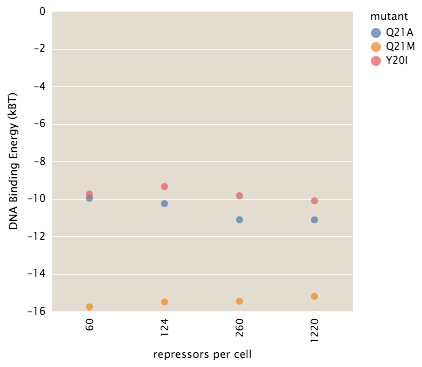

In [14]:
# Plot the estimated parameter values. 
base = alt.Chart(prof_ind_stats, width=300, height=300).interactive()

points = base.mark_point(filled=True, size=50).encode(
        x=alt.X('repressors:O', axis={'title':'repressors per cell'}),
        y=alt.Y('mode:Q', axis={'title':'DNA Binding Energy (kBT)'}),
        color='mutant:N')

points

In [15]:
def compute_pairwise_predictions_R(point_df, stat_df,constants):
    # Get the
    reps = stat_df['repressors'].unique()
    mutants = stat_df['mutant'].unique()
    point_df = point_df.copy() 
    point_df['min'] = point_df['mean'].values - point_df['sem'].values
    point_df['max'] = point_df['mean'].values + point_df['sem'].values
    point_df['class'] = 'experiment'
    point_df.rename(columns={'mean':'fc'}, inplace=True) 
    point_df.drop('sem', axis=1, inplace=True)
    dfs = []
    for predictor in reps:
        # Isolate the parameters
        mode = stat_df[stat_df['repressors']==predictor]['mode'].values
        hpd_min = stat_df[stat_df['repressors']==predictor]['hpd_min'].values
        hpd_max = stat_df[stat_df['repressors']==predictor]['hpd_max'].values
        epR = np.array([mode, hpd_min, hpd_max]).T
    
        
        # Mesh the parameters with the valid range of IPTG values
        c_range = np.logspace(np.floor(np.log10(point_df['IPTGuM'].values.min())) - 1,
                             np.ceil(np.log10(point_df['IPTGuM'].values.max())), 200)
        c_mesh, epR_mesh, R_mesh= np.meshgrid(c_range, epR, reps) 
        
        # Compute the fold-change.
        fc = mut.thermo.SimpleRepression(R=R_mesh, ep_r=epR_mesh, effector_conc=c_mesh,
                                         n_ns=constants['Nns'], ep_ai=constants['ep_AI'], 
                                         ka=constants['ka'], ki=constants['ki']).fold_change()
        for i, r in enumerate(reps):
            rep_fc = fc[:, :, i]
            z = 0
            for j in range(0, np.shape(fc)[0], 3):
                _point_df = point_df.copy()
                rep_mut_fc = rep_fc[j:j+3,:]
                _df = pd.DataFrame(rep_mut_fc.T, columns=['fc', 'min', 'max'])
                _df['IPTGuM'] = c_range
                _df['repressors'] = r
                _df['mutant'] = mutants[z] 
                _df['predictor'] = predictor
                _df['class'] = 'theory'
                dfs.append(_df)
                _point_df['predictor'] = predictor
                dfs.append(_point_df)
                z += 1


    return pd.concat(dfs, sort=False)

In [16]:
facet_df = compute_pairwise_predictions_R(DNA_summ[DNA_summ['IPTGuM'] > 0], prof_ind_stats, constants)

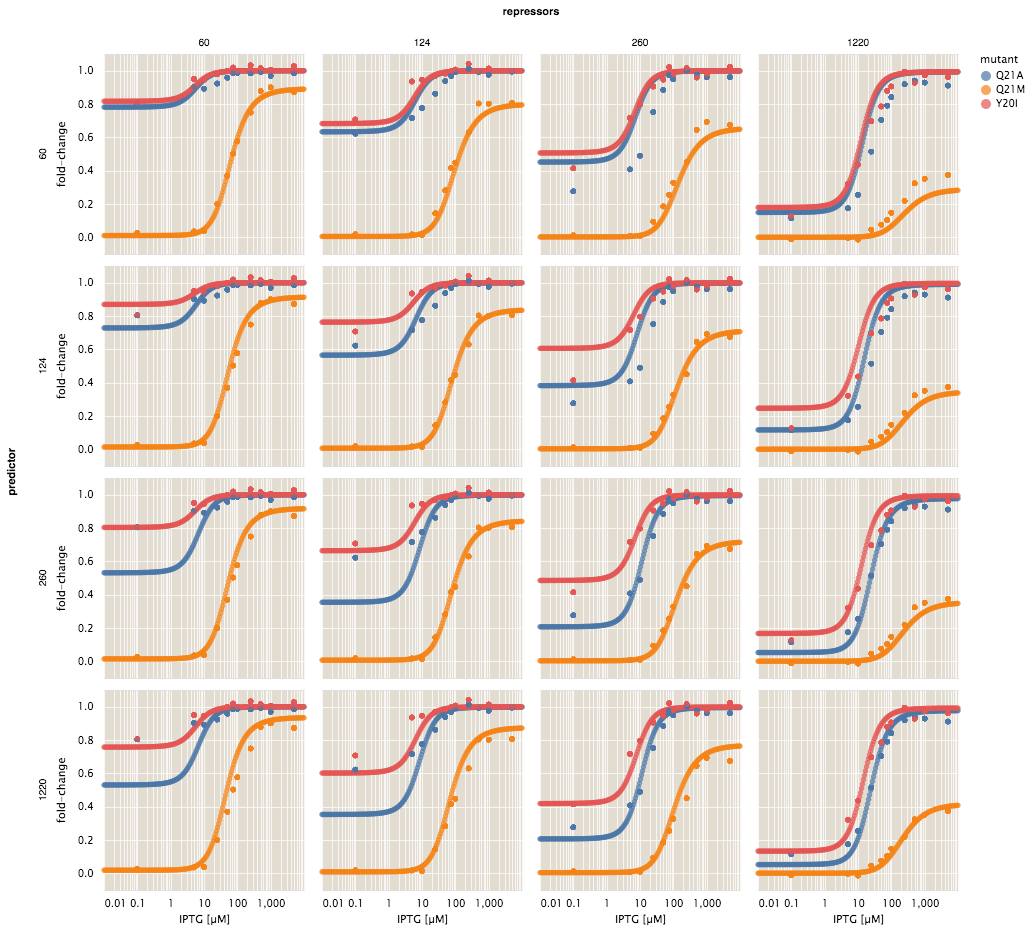

In [17]:
base = alt.Chart(facet_df)
modes = base.mark_point(filled=True).encode(
    x=alt.X('IPTGuM:Q', scale={'type':'log'}, axis={'title':'IPTG [µM]'}),
    y=alt.Y('fc:Q', axis={'title':'fold-change'}),
    color='mutant:N').facet(column='repressors:O', row='predictor:O')  
modes

## Fitting Ka/Ki for Inducer Binding Domain Mutants


In [18]:
# Assemble the stan model. 
kaki_model_code = mut.bayes.assemble_StanModelCode('../stan/KaKi_fitting.stan', '../stan/functions.stan')
kaki_model = pystan.StanModel(model_code=kaki_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_21b14a2aa83ccb8517640908731252e0 NOW.


In [19]:
# Assemble the mutant identifiers. 
IND_idx = {m:i+1 for i, m in enumerate(IND_data['mutant'].unique())}
for m, idx in IND_idx.items():
    IND_data.loc[IND_data['mutant']==m, 'idx'] = idx

IND_data['idx'] = IND_data['idx'].values.astype(int)

In [20]:
# assemble the data dict
data_dict = dict(J=len(IND_idx), N=len(IND_data), idx=IND_data['idx'],
                R=IND_data['repressors'], Nns=constants['Nns'],
                c=IND_data['IPTGuM'], ep_RA=constants['O2'],
                ep_AI=constants['ep_AI'], n_sites=constants['n_sites'],
                fc=IND_data['fold_change'])

# Sample!
kaki_samples = kaki_model.sampling(data_dict, iter=5000, chains=4, pars=['Ka', 'Ki'])
kaki_samples.to_csv('../../data/csv/KaKi_fitting_samples.csv', index=False)

AttributeError: 'stanfit4anon_model_21b14a2aa83ccb8517640908731252e' object has no attribute 'to_csv'

In [21]:
# Generate the data frame and rename columns as needed.
new_names = {'K{}.{}'.format(n,i):'K{}.{}'.format(n, m) for m, i in IND_idx.items() for n in ['a', 'i']}
kaki_df = mut.bayes.chains_to_dataframe(kaki_samples)
kaki_df.rename(columns=new_names, inplace=True)
kaki_stats = mut.stats.compute_statistics(kaki_df)
kaki_stats.to_csv('../../data/csv/KaKi_fitting_stats.csv', index=False)

In [22]:
# Compute the modes and credible regions. 
fit_dfs = []
c_range = np.logspace(-2, 4, 200)
for i, m in enumerate(IND_idx):
    best_fit = mut.thermo.SimpleRepression(R=constants['RBS1027'], ep_r=constants['O2'], ep_ai=constants['ep_AI'],
                                          effector_conc=c_range, ka=kaki_stats[kaki_stats['parameter']=='Ka.{}'.format(m)]['mode'].values,
                                          ki=kaki_stats[kaki_stats['parameter']=='Ki.{}'.format(m)]['mode'].values, n_ns=constants['Nns'],
                                          n_sites=constants['n_sites']).fold_change()
    cred_region = np.zeros([2, len(c_range)])
    for j, c in enumerate(c_range):
        arch = mut.thermo.SimpleRepression(R=constants['RBS1027'], ep_r=constants['O2'], ep_ai=constants['ep_AI'],
                                            effector_conc=c, ka=kaki_df['Ka.{}'.format(m)], ki=kaki_df['Ki.{}'.format(m)],
                                          n_ns=constants['Nns'], n_sites=constants['n_sites']).fold_change()
        cred_region[:, j] = mut.stats.compute_hpd(arch, 0.95)
    
    # Assemble the data frame. 
    _df = pd.DataFrame(np.array([c_range, best_fit, cred_region[0, :], cred_region[1, :]]).T, columns=['IPTGuM', 'mode', 'min', 'max'])
    _df['mutant'] = m
    fit_dfs.append(_df)
fit_df = pd.concat(fit_dfs)

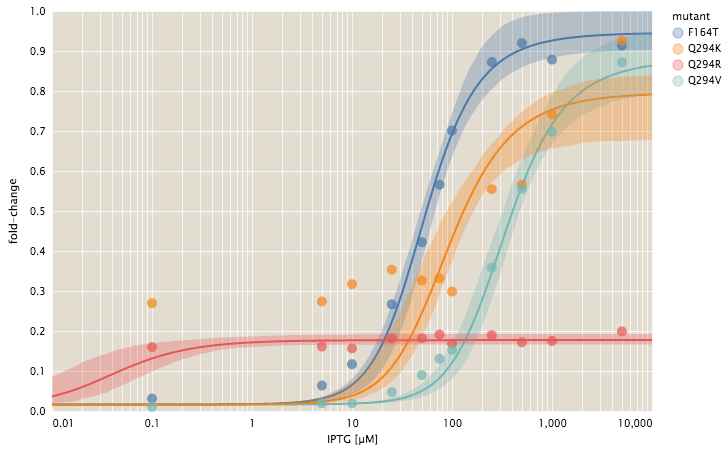

In [23]:
fit_base = alt.Chart(fit_df, width=600, height=400)
data_base = alt.Chart(IND_summ[IND_summ['IPTGuM'] > 0])

fit_mode = fit_base.mark_line().encode(
            x = alt.X('IPTGuM:Q', scale={'type':'log'}, axis={'title':'IPTG [µM]'}),
            y = alt.Y('mode:Q', axis={'title':'fold-change'}),
            color='mutant:N')

fit_hpd = fit_base.mark_area(opacity=0.3).encode(
          x='IPTGuM:Q', 
          y='min:Q', 
          y2='max:Q',
          color='mutant:N')

points = data_base.mark_point(filled=True, size=100).encode(
        x='IPTGuM:Q',
        y='mean',
        color='mutant:N')

fit_mode + fit_hpd + points

In [24]:
kaki_stats[kaki_stats['parameter']=='Ki.{}'.format(m)]['mode']

7    0.000673
Name: mode, dtype: float64

### Examining changes to other parameters

The above plot shows that for two of the single mutants, it's fair to use the wild-type O2 binding energy of -13.9 $k_BT$. However, there appears to be some non ideal problems with the other mutants, Q294K and Q294R. It i possible that these mutants are altering the DNA binding energy in some way, or altering the energetic difference between the allosteric states, $\Delta\varepsilon_{AI}$. Since we have measurements of the leakiness, and have them for other operators, we should be able to see if fitting the allosteric energy difference given the leakiness data to one operator, followed by fitting of the KaKi, could improve the predictions. 

In [ ]:
ep_AI_model_code = mut.bayes.assemble_StanModelCode('../stan/allosteric_energy.stan', '../stan/functions.stan')
ep_AI_model = pystan.StanModel(model_code=ep_AI_model_code)

In [ ]:
# Assemble the data dictionary. 
IND_leak_data = IND_data[IND_data['IPTGuM'] == 0]
data_dict = dict(J=len(IND_idx), N=len(IND_leak_data), idx=IND_leak_data['idx'], 
                R=IND_leak_data['repressors'], Nns=constants['Nns'], ep_RA=constants['O2'],
                fc=IND_leak_data['fold_change'])
ep_AI_samples = ep_AI_model.sampling(data_dict, iter=5000, chains=4, pars=['ep'])

In [ ]:
# Rename and format data_frame. 
ep_AI_df = mut.bayes.chains_to_dataframe(ep_AI_samples)
new_names = {'ep_ai.{}'.format(i):'ep_AI.{}'.format(m) for m, i in IND_idx.items()}
ep_AI_df.rename(columns=new_names, inplace=True)
ep_AI_stats = mut.stats.compute_statistics(ep_AI_df)
ep_AI_stats

In [ ]:
# Compute the best and hpd for leakiness. 
rep_range = np.logspace(0, 4, 200)
allo_leak_dfs = []
for i, m in enumerate(IND_idx):
    ep_AI = ep_AI_stats[ep_AI_stats['parameter']=='ep_AI.{}'.format(m)][['mode', 'hpd_min', 'hpd_max']].values
    R_mesh, ep_AI_mesh = np.meshgrid(rep_range, ep_AI)
    fc = mut.thermo.SimpleRepression(R=R_mesh, ep_r=constants['O2'], effector_conc=0, ka=1, ki=1,
                                    ep_ai=ep_AI_mesh).fold_change()
    _df = pd.DataFrame(fc.T, columns=['mode', 'min', 'max'])
    _df['repressors'] = rep_range
    _df['mutant'] = m
    allo_leak_dfs.append(_df)
allo_leak = pd.concat(allo_leak_dfs)

In [ ]:
# Set up the base plots for theory and experiment
leak_base = alt.Chart(IND_summ[IND_summ['IPTGuM'] == 0], width=600, height=400)
allo_fit_base = alt.Chart(allo_leak, width=600, height=400)

# Plot the fit lines and credible regions
best_fit = allo_fit_base.mark_line().encode(
        x=alt.X('repressors:Q', scale={'type':'log'}, axis={'title':'repressors per cell'}),
        y=alt.Y('mode:Q', scale={'type':'log'}, axis={'title':'fold-change'}),
        color='mutant:N')
hpds = allo_fit_base.mark_area(opacity=0.2).encode(
        x=alt.X('repressors:Q'),
        y='min:Q',
        y2='max:Q',
        color='mutant:N')


# Plot the data. 
leak_points = leak_base.mark_point(filled=True, size=100).encode(
                                x='repressors:Q',
                                y='mean:Q',
                                color='mutant:N')
best_fit + hpds + leak_points

This is a pretty interesting fit. It seems that fitting $\Delta\varepsilon_{AI}$ shows that the two "problem" mutants leads to relatively narrow credible regions. Using these new values, we can fit Ka and Ki. We will ignore the credible regions and consider only the mode for each. Note that the wild-type value, 4.5 $k_BT$ is used for mutant F164T and Q294V. 

In [25]:
kaki_allo_model_code = mut.bayes.assemble_StanModelCode('../stan/KaKi_fitting_informative_allosteric_energy.stan',
                                                        '../stan/functions.stan')
kaki_allo_model = pystan.StanModel(model_code=kaki_allo_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9a90f7f3e133637ef633f6d0c2baaab7 NOW.


In [26]:
# Assemble the data dictionary. 
# ep_AI_dict = {m: ep_AI_stats[ep_AI_stats['parameter']=='ep_AI.{}'.format(m)]['mode'].values[0] for m in IND_idx.keys()}
# ep_AI_dict['F164T'] = constants['ep_AI']
# ep_AI_dict['Q294V'] = constants['ep_AI']

# Assemble the data dictionary
data_dict = dict(J=len(IND_data['mutant'].unique()), N=len(IND_data),
                 idx=IND_data['idx'], R=constants['RBS1027'], Nns=constants['Nns'], c=IND_data['IPTGuM'],
                 ep_RA=constants['O2'], n_sites=constants['n_sites'],
                 fc=IND_data['fold_change'])                 

In [27]:
kaki_allo_samples = kaki_allo_model.sampling(data_dict, iter=5000, thin=10, chains=4) #, pars=['Ka', 'Ki', 'ep_AI',])

In [28]:
kaki_allo_samples

Inference for Stan model: anon_model_9a90f7f3e133637ef633f6d0c2baaab7.
4 chains, each with iter=5000; warmup=2500; thin=10; 
post-warmup draws per chain=250, total post-warmup draws=1000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Ka[0]    1843.6   51.26 1620.9 536.27 908.11 1290.8 2000.7 7161.6   1000    1.0
Ka[1]    2310.1   89.09 2817.2 138.19 292.06 691.28 3811.7 9286.5   1000    1.0
Ka[2]    3767.8   53.69 1697.7 1696.7 2576.3 3290.4 4568.6 8077.9   1000    1.0
Ka[3]    6813.1   82.65 2217.6 1977.7 5237.3 7122.2 8714.6 9905.4    720    1.0
Ki[0]     53.75    0.95  29.94   4.56  31.03  50.91  73.49 120.67   1000    1.0
Ki[1]     12.64    0.21   6.06   2.26   8.24  12.18   16.4  25.88    853    1.0
Ki[2]    357.69    1.69  50.98  266.5 322.57 353.91  389.5 464.15    910    1.0
Ki[3]    5442.9   63.49 1703.5 1762.6 4255.4 5601.4 6735.2 8247.4    720    1.0
ep_AI[0]   0.14    0.04   1.29  -1.22  -0.63  -0.21   0.49   3.86    888    1.0
ep_AI[1]  -

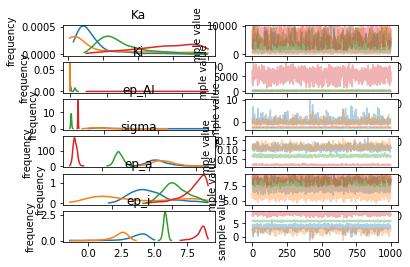

In [29]:
%matplotlib inline
_ = kaki_allo_samples.plot()

In [30]:
new_names = {'K{}.{}'.format(n,i):'K{}.{}'.format(n, m) for m, i in IND_idx.items() for n in ['a', 'i']}
new_names.update({'ep_AI.{}'.format(i):'ep_AI.{}'.format(m) for m, i in IND_idx.items()})
kaki_allo_df = mut.bayes.chains_to_dataframe(kaki_allo_samples)
kaki_allo_df.rename(columns=new_names, inplace=True)
kaki_allo_stats = mut.stats.compute_statistics(kaki_allo_df)
kaki_allo_stats.to_csv('../../data/csv/KaKi_fitting_variable_epAI_stats.csv', index=False)

In [31]:
# Compute the modes and credible regions. 
fit_dfs = []
c_range = np.logspace(-2, 4, 200)
for i, m in enumerate(IND_idx):
    best_fit = mut.thermo.SimpleRepression(R=constants['RBS1027'], ep_r=constants['O2'], ep_ai=kaki_allo_stats[kaki_allo_stats['parameter']=='ep_AI.{}'.format(m)]['mode'].values,
                                          effector_conc=c_range, ka=kaki_allo_stats[kaki_allo_stats['parameter']=='Ka.{}'.format(m)]['mode'].values,
                                          ki=kaki_allo_stats[kaki_allo_stats['parameter']=='Ki.{}'.format(m)]['mode'].values, n_ns=constants['Nns'],
                                          n_sites=constants['n_sites']).fold_change()
    cred_region = np.zeros([2, len(c_range)])
    for j, c in enumerate(c_range):
        arch = mut.thermo.SimpleRepression(R=constants['RBS1027'], ep_r=constants['O2'], ep_ai=kaki_allo_df['ep_AI.{}'.format(m)],
                                            effector_conc=c, ka=kaki_allo_df['Ka.{}'.format(m)], ki=kaki_allo_df['Ki.{}'.format(m)],
                                          n_ns=constants['Nns'], n_sites=constants['n_sites']).fold_change()
        cred_region[:, j] = mut.stats.compute_hpd(arch, 0.95)
    
    # Assemble the data frame. 
    _df = pd.DataFrame(np.array([c_range, best_fit, cred_region[0, :], cred_region[1, :]]).T, columns=['IPTGuM', 'mode', 'min', 'max'])
    _df['mutant'] = m
    fit_dfs.append(_df)
fit_df = pd.concat(fit_dfs)

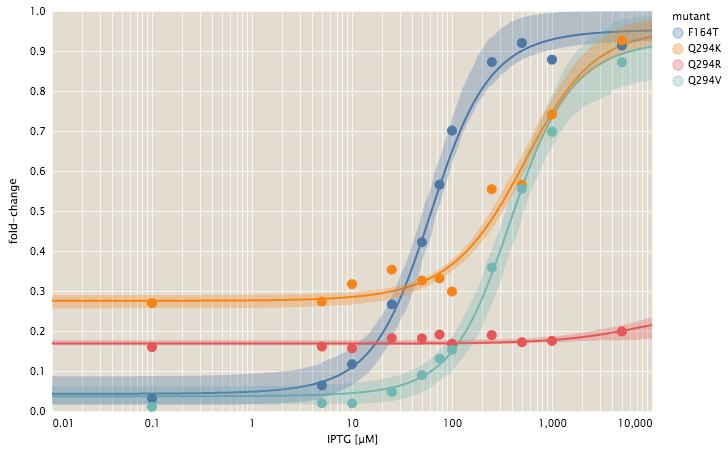

In [32]:
fit_base = alt.Chart(fit_df, width=600, height=400)
data_base = alt.Chart(IND_summ[IND_summ['IPTGuM'] > 0])

fit_mode = fit_base.mark_line().encode(
            x = alt.X('IPTGuM:Q', scale={'type':'log'}, axis={'title':'IPTG [µM]'}),
            y = alt.Y('mode:Q', axis={'title':'fold-change'}),
            color='mutant:N')

fit_hpd = fit_base.mark_area(opacity=0.3).encode(
          x='IPTGuM:Q', 
          y='min:Q', 
          y2='max:Q',
          color='mutant:N')

points = data_base.mark_point(filled=True, size=100, opacity=1).encode(
        x='IPTGuM:Q',
        y='mean',
        color='mutant:N')

fit_mode + fit_hpd + points

The real test now comes to being able to predict other operators

In [33]:
# Isolate the O1 data
IND_O1 = full_data[(full_data['class']=='IND') & (full_data['operator']=='O1')]
IND_O1_muts = IND_O1['mutant'].unique()
IND_O1_summ = pd.DataFrame(IND_O1.groupby(['mutant', 'IPTGuM']).apply(mut.stats.compute_mean_sem)).reset_index()


# Compute the modes and credible regions. 
O1_pred_dfs = []
c_range = np.logspace(-2, 4, 200)
for i, m in enumerate(['Q294K', 'Q294R']):
    best_fit = mut.thermo.SimpleRepression(R=constants['RBS1027'], ep_r=constants['O1'], ep_ai=kaki_allo_stats[kaki_allo_stats['parameter']=='ep_AI.{}'.format(m)]['mode'].values,
                                          effector_conc=c_range, ka=kaki_allo_stats[kaki_allo_stats['parameter']=='Ka.{}'.format(m)]['mode'].values,
                                          ki=kaki_allo_stats[kaki_allo_stats['parameter']=='Ki.{}'.format(m)]['mode'].values, n_ns=constants['Nns'],
                                          n_sites=constants['n_sites']).fold_change()
    cred_region = np.zeros([2, len(c_range)])
    for j, c in enumerate(c_range):
        arch = mut.thermo.SimpleRepression(R=constants['RBS1027'], ep_r=constants['O1'], ep_ai=kaki_allo_df['ep_AI.{}'.format(m)],
                                            effector_conc=c, ka=kaki_allo_df['Ka.{}'.format(m)], ki=kaki_allo_df['Ki.{}'.format(m)],
                                          n_ns=constants['Nns'], n_sites=constants['n_sites']).fold_change()
        cred_region[:, j] = mut.stats.compute_hpd(arch, 0.95)
    
    # Assemble the data frame. 
    _df = pd.DataFrame(np.array([c_range, best_fit, cred_region[0, :], cred_region[1, :]]).T, columns=['IPTGuM', 'mode', 'min', 'max'])
    _df['mutant'] = m
    O1_pred_dfs.append(_df)
O1_pred_df = pd.concat(O1_pred_dfs)

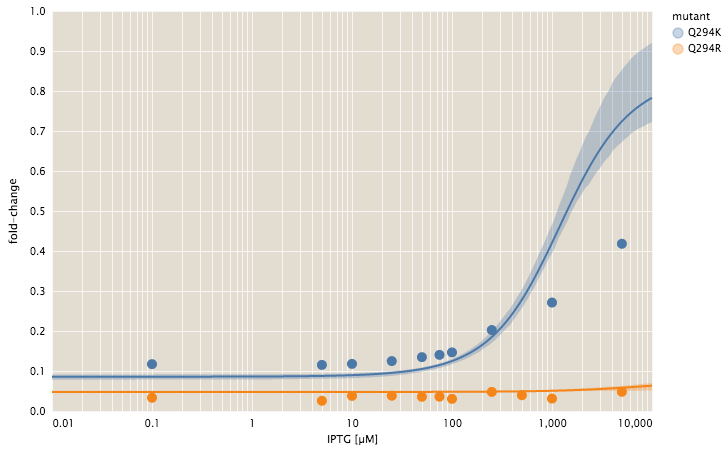

In [34]:
fit_base = alt.Chart(O1_pred_df, width=600, height=400)
data_base = alt.Chart(IND_O1_summ[IND_O1_summ['IPTGuM'] > 0])

fit_mode = fit_base.mark_line().encode(
            x = alt.X('IPTGuM:Q', scale={'type':'log'}, axis={'title':'IPTG [µM]'}),
            y = alt.Y('mode:Q', axis={'title':'fold-change'}),
            color='mutant:N')

fit_hpd = fit_base.mark_area(opacity=0.3).encode(
          x='IPTGuM:Q', 
          y='min:Q', 
          y2='max:Q',
          color='mutant:N')

points = data_base.mark_point(filled=True, size=100, opacity=1).encode(
        x='IPTGuM:Q',
        y='mean',
        color='mutant:N')

fit_mode + fit_hpd + points

## Double Mutant Error Propagation 

In [98]:
# Load the model.
dbl_error_model_code = mut.bayes.assemble_StanModelCode('../stan/DBL_error_propagation.stan', '../stan/functions.stan')
dbl_error_model = pystan.StanModel(model_code=dbl_error_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c48e4477132c0f59791d43316185f59a NOW.


In [109]:
# Add mutant identifiers
DBL_idx = {m:i+1 for i, m in enumerate(DBL_data['mutant'].unique())}
DNA_muts, IND_muts = [], []
for m, i in DBL_idx.items():
    DNA_mut, IND_mut = m.split('-')
    DNA_muts.append(DNA_mut)
    IND_muts.append(IND_mut)
    DBL_data.loc[DBL_data['mutant'] == m, 'ind_idx'] = IND_idx[IND_mut]
    DBL_data.loc[DBL_data['mutant'] == m, 'dna_idx'] = DNA_idx[DNA_mut]
    DBL_data.loc[DBL_data['mutant'] == m, 'dbl_idx'] = DBL_idx[m]
DBL_data['ind_idx'] = DBL_data['ind_idx'].astype('int')
DBL_data['dna_idx'] = DBL_data['dna_idx'].astype('int')
DBL_data['dbl_idx'] = DBL_data['dbl_idx'].astype('int')
DNA_muts = list(set(DNA_muts))                                       
IND_muts = list(set(IND_muts))                                       
# Assemble the informative priors for DNA binding domain. 
ep_RA_mu, ep_RA_sig = [], []
for m in DNA_muts:
    ep_RA_mu.append(np.mean(prof_ind_df['ep_RA.{}.{}'.format(m, constants['RBS1027'])]))
    ep_RA_sig.append(np.var(prof_ind_df['ep_RA.{}.{}'.format(m, constants['RBS1027'])]))
    
Ka_mu, Ka_sig, Ki_mu, Ki_sig = [], [], [], []  
ep_AI_mu, ep_AI_sig = [], []
for m in IND_muts:
    if m not in ['F164T', 'Q294V']:
        Ka_mu.append(np.mean(kaki_allo_df['Ka.{}'.format(m)]))
        Ka_sig.append(np.var(kaki_allo_df['Ka.{}'.format(m)]))
        Ki_mu.append(np.mean(kaki_allo_df['Ki.{}'.format(m)]))
        Ki_sig.append(np.var(kaki_allo_df['Ki.{}'.format(m)]))
        ep_AI_mu.append(np.mean(kaki_allo_df['ep_AI.{}'.format(m)]))
        ep_AI_sig.append(np.var(kaki_allo_df['ep_AI.{}'.format(m)]))
    else: 
        Ka_mu.append(np.mean(kaki_df['Ka.{}'.format(m)]))
        Ka_sig.append(np.var(kaki_df['Ka.{}'.format(m)]))
        Ki_mu.append(np.mean(kaki_df['Ki.{}'.format(m)])) 
        Ki_sig.append(np.var(kaki_df['Ki.{}'.format(m)]))
        ep_AI_mu.append(4.5)
        ep_AI_sig.append(1e-9)

In [112]:
# Assemble the data dictionary. 
data_dict = dict(J_DNA=len(DNA_muts), J_IND=len(IND_muts), J=len(DBL_data['mutant'].unique()),
                 N=len(DBL_data), DNA_idx=DBL_data['dna_idx'], IND_idx=DBL_data['ind_idx'],
                 idx=DBL_data['dbl_idx'],
                 Nns=constants['Nns'], R=constants['RBS1027'], n_sites=constants['n_sites'],
                 c=DBL_data['IPTGuM'], ep_AI_mu=ep_AI_mu, ep_AI_sig=ep_AI_sig,
                 ep_RA_mu=ep_RA_mu, ep_RA_sig=ep_RA_sig, Ka_mu=Ka_mu, Ka_sig=Ka_sig,
                 Ki_mu=Ki_mu, Ki_sig=Ki_sig, fc=DBL_data['fold_change'])
dbl_error_samples = dbl_error_model.sampling(data_dict, iter=5000, chains=3, thin=10)

In [113]:
dbl_error_samples

Inference for Stan model: anon_model_c48e4477132c0f59791d43316185f59a.
3 chains, each with iter=5000; warmup=2500; thin=10; 
post-warmup draws per chain=250, total post-warmup draws=750.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ep_RA[0]  -3.72    0.81   1.15   -4.8   -4.8  -4.23  -2.14  -2.14      2    nan
ep_RA[1]  -0.85    0.36   0.51  -1.52  -1.52  -0.75  -0.28  -0.28      2    nan
ep_RA[2]  -2.31    1.18   1.66  -4.58  -4.58  -1.69  -0.65  -0.65      2    nan
Ka[0]      1.29    0.46   0.65   0.44   0.44   1.43   2.01   2.01      2    nan
Ka[1]       2.2    1.88   2.66   0.29   0.29   0.36   5.97   5.97      2    nan
Ka[2]       1.4    0.97   1.37   0.29   0.29   0.58   3.32   3.32      2    nan
Ki[0]      0.29     0.1   0.14   0.19   0.19    0.2   0.49   0.49      2    nan
Ki[1]      1.35    0.52   0.74   0.69   0.69   0.97   2.37   2.37      2    nan
Ki[2]      1.42    0.58   0.82   0.28   0.28   1.85   2.15   2.15      2    nan
ep_AI[0]    

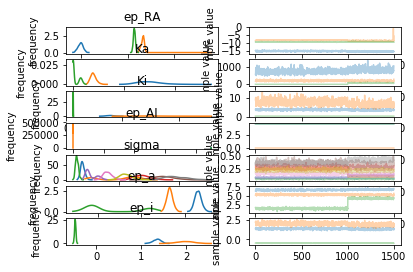

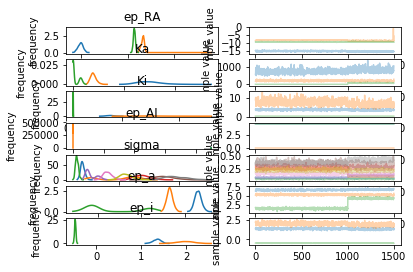

In [108]:
dbl_error_samples.plot()

In [55]:
IND_muts

['Q294V', 'Q294K', 'F164T']